# Point-by-point mapping notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to perform a point-by-point index of the 2D peaks you segmented.
The point-by-point results (usually saved to a .txt file in the sample PROCESSED_DATA folder) are multi-valued (we can find multiple UBIs at each map voxel).  
You can view the results of the point-by-point process 'live' by running the next notebook (pbp_2_visualise).  
That notebook will also allow you to save a single-valued version of the pbp map to H5, ParaView XDMF and MTEX CTF.
The UBIs we find from the PBP index should have reasonably accurate orientations, but the strains are likely to be poor.  
To get much better strains, slightly better orientations and possibly better grain shapes, you should run pbp_3_refinement
Then run 4_visualise to convert the refinement results to an accurate single-valued map with good strains.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# filter the columnfile to discard weak peaks
minpkint = 5

# point-by-point parameters
hkl_tol = 0.025
fpks = 0.9
ds_tol = 0.004
etacut = 0.1
ifrac = 5e-3
y0 = 0.0
symmetry = "cubic"
foridx = [0, 1, 3, 5, 7]
forgen = [1, 5, 7]
uniqcut = 0.85
use_cluster = False

# EXPERTS: Can specify par_file as a parameter if you want
par_file = None

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
par_file = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/pars/pars.json"
phase_str = "Au"
minpkint = 5
hkl_tol = 0.03
fpks = 30
ds_tol = 0.008
etacut = 0.1
ifrac = 0.002
y0 = -16.0
symmetry = "cubic"
foridx = [0, 3, 5, 7]
forgen = [0, 5, 7]
uniqcut = 0.85
use_cluster = False
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [5]:
import numpy as np
from matplotlib import pyplot as plt

import ImageD11.sinograms.point_by_point
import ImageD11.sinograms.dataset
import ImageD11.columnfile

import ImageD11.nbGui.nb_utils as utils

%matplotlib ipympl

# Load data
## Dataset

In [6]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Parameters
Specify the path to your parameter file

In [7]:
if par_file is None:
    par_file = os.path.join(ds.analysisroot, 'pars.json')
ds.parfile = par_file
ds.save()

## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [8]:
ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [9]:
ucell = ds.phases.unitcells[phase_str]
print(ucell)

Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


## Peaks

In [10]:
cf_2d = ds.get_cf_2d()
ds.update_colfile_pars(cf_2d, phase_name=phase_str)
if not os.path.exists(ds.col2dfile):
    # save the 2D peaks to file so we don't have to spatially correct them again
    ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_2d.h5
Reading your columnfile in hdf format


In [11]:
# filter the columnfile to discard weak peaks

cf_2d.filter(cf_2d.Number_of_pixels > minpkint)

In [12]:
cosine_tol=np.cos(np.radians(90 - ds.ostep))

pbp_object = ImageD11.sinograms.point_by_point.PBP(ds.parfile,
                                                    ds,
                                                    hkl_tol=hkl_tol,
                                                    fpks=fpks,
                                                    ds_tol=ds_tol,
                                                    etacut=etacut,
                                                    ifrac=ifrac,
                                                    cosine_tol=cosine_tol,
                                                    y0=y0,
                                                    symmetry=symmetry,
                                                    foridx=foridx,
                                                    forgen=forgen,
                                                    uniqcut=uniqcut,
                                                    phase_name=phase_str)

# make icolf filename phase-aware
icolf_filename = ds.icolfile.replace('.h5', f'_{phase_str}.h5')
grains_filename = ds.pbpfile.replace('.txt', f'_{phase_str}.txt')

pbp_object.setpeaks(cf_2d, icolf_filename=icolf_filename)

0 0.4325 (1, 1, 1) 8 127755 used, sum_intensity> 55.226
1 0.4994 (0, 2, 0) 6 skipped
2 0.7062 (2, 2, 0) 12 skipped
3 0.8281 (1, 1, 3) 24 104173 used, sum_intensity> 13.542
4 0.8649 (2, 2, 2) 8 skipped
5 0.9988 (0, 4, 0) 6 17562 used, sum_intensity> 7.386
6 1.0884 (3, 1, 3) 24 skipped


7 1.1166 (4, 0, 2) 24 32549 used, sum_intensity> 7.694
8 1.2232 (2, 4, 2) 24 skipped
9 1.2974 (5, 1, 1) 32 skipped
10 1.4124 (4, 4, 0) 12 skipped
11 1.4772 (1, 3, 5) 48 skipped
12 1.4981 (6, 0, 0) 30 skipped
13 1.5792 (0, 2, 6) 24 skipped
14 1.6373 (3, 3, 5) 24 skipped
15 1.6562 (2, 6, 2) 24 skipped
16 1.7299 (4, 4, 4) 8 skipped
17 1.7831 (1, 5, 5) 48 skipped
18 1.8005 (6, 0, 4) 24 skipped
19 1.8685 (4, 2, 6) 48 skipped
20 1.9179 (5, 3, 5) 72 skipped
21 1.9975 (8, 0, 0) 6 skipped
22 2.0438 (3, 3, 7) 24 skipped
23 2.0590 (4, 4, 6) 48 skipped
24 2.1187 (0, 6, 6) 36 skipped
25 2.1624 (5, 5, 5) 56 skipped
26 2.1767 (6, 6, 2) 24 skipped


Using for indexing: 282039 npks, minpks, forgen 62 30 [0, 5, 7]


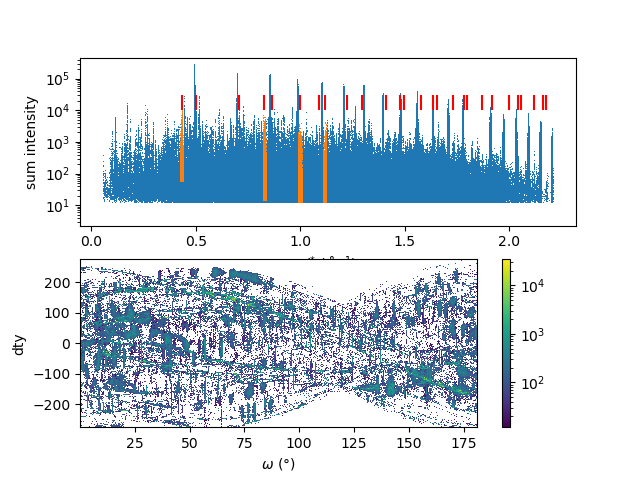

In [13]:
fig, ax = pbp_object.iplot(skip=1)  # increase skip to make plot faster

# Indexing

In [14]:
if use_cluster:
    bash_script_path = utils.prepare_pbp_bash(pbp_object, PYTHONPATH, minpkint)
    utils.slurm_submit_and_wait(bash_script_path, 15)
else:
    pbp_object.point_by_point(grains_filename, loglevel=3)

{'cosine_tol': 0.002181658028916515,
 'ds_tol': 0.008,
 'forgen': [0, 5, 7],
 'hkl_tol': 0.03,
 'hmax': 4,
 'minpks': 30,
 'uniqcut': 0.85,
 'y0': -16.0,
 'ymin': -274.00012223777037,
 'ystep': 2.000000892246499}


Done  32.262 %, average grains/point   2.01, 0.003 /s/point, total 70.7 /s

172.3971767425537 seconds 0.0020358424763825852 s per point
172.27436518669128 seconds 0.0020343921917158666 s per point without setup


In [15]:
ds.save()